<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/CIFAR_Hybrid_QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 5.4MB/s 
     |████████████████████████████████| 18.0MB 214kB/s 
     |████████████████████████████████| 235kB 45.4MB/s 
     |████████████████████████████████| 215kB 42.5MB/s 
     |████████████████████████████████| 2.1MB 19.0MB/s 
     |████████████████████████████████| 1.5MB 41.1MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 194kB 35.5MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 614kB 37.7MB/s 
     |████████████████████████████████| 3.2MB 19.6MB/s 
     |████████████████████████████████| 6.3MB 17.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=28690353badd83b862a0776b892f78f3a6e8f9782d24d4a50a995941e2111a57
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

To connect PyTorch to Qiskit, we need to define a function that converts tensors so obtained from PyTorch to a list so that the list could be fed into the Quantum Circuit in Qiskit.

In [4]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [3]:

import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

We use a 1 qubit circuit with 1 trainable parameter to create a 'Quantum Class'

In [5]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

To measure the output (in the z basis), the expectation must be calculated, so let's test the implementation below

In [6]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.55


┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ RY(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

**Creating the quantum classical hybrid class using Pytorch**

The functions needed for backpropagation can be created by PyTorch (using the parameter shift rule). The forward and backward passes contain elements from the Qiskit class

In [7]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

## **Data loading and pre-processing**

Here , we create a simple hybrid neural network to classify images of two types ; Aeroplanes and Automobiles (labelled 0 and 1) from the CIFAR-10 dataset.

Let's first load the training data

In [8]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


We now filter for pictures containing Aeroplanes and Automobiles (labelled 0 and 1 respectively)

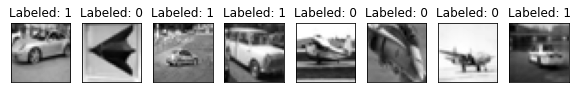

In [11]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))
      
    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

Now let's look at the testing data

In [13]:
#Testing data

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels1 = cifar_testset.targets # get the labels for the data
labels1 = np.array(labels1)

idx1_ae = np.where(labels1 == 0) # filter on aeroplanes
idx2_au = np.where(labels1 == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)

n=50

# concatenate the data indices
idxa = np.concatenate((idx1_ae[0][0:n],idx2_au[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idxa] 
cifar_testset.data = cifar_testset.data[idxa]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

Files already downloaded and verified


**Creating the hybrid Neural Network**

We create a typical Convolutional Neural Network with two fully-connected layers at the end. The value of the last neuron of the fully-connected layer is fed as the parameter  
θ
  into our quantum circuit.

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [ ]:
#qc = TorchCircuit.apply 
Ignore this cell
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(500, 500)
        self.h2 = nn.Linear(500, 1)

    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  # Normalise the inputs to 1 or 0
        x = torch.cat((x, 1-x), -1)
        return x

**Now let's train the network**

We can specify any PyTorch optimiser (here we use the Adam optimiser), learning rate and cost/loss function in order to train over multiple epochs. In this instance, we use  a learning rate of 0.001 and the negative log-likelihood loss function.
We then plot the training graph. We do this for 5, 10, 20, 30 epochs

Training [20%]	Loss: -0.4902
Training [40%]	Loss: -0.5144
Training [60%]	Loss: -0.6281
Training [80%]	Loss: -0.6976
Training [100%]	Loss: -0.7317


Text(0, 0.5, 'Neg Log Likelihood Loss')

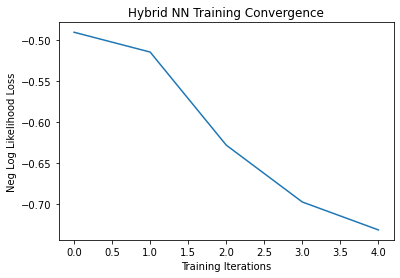

In [15]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

#Now plotting the training graph
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')


Training [10%]	Loss: -0.5159
Training [20%]	Loss: -0.4951
Training [30%]	Loss: -0.4875
Training [40%]	Loss: -0.4503
Training [50%]	Loss: -0.4995
Training [60%]	Loss: -0.5259
Training [70%]	Loss: -0.5036
Training [80%]	Loss: -0.5060
Training [90%]	Loss: -0.5313
Training [100%]	Loss: -0.5192


Text(0, 0.5, 'Neg Log Likelihood Loss')

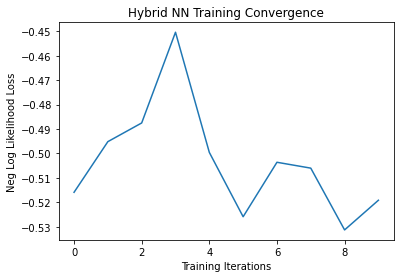

In [16]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list1 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list1.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list1[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list1)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Training [5%]	Loss: -0.5055
Training [10%]	Loss: -0.5753
Training [15%]	Loss: -0.6327
Training [20%]	Loss: -0.6598
Training [25%]	Loss: -0.7136
Training [30%]	Loss: -0.7128
Training [35%]	Loss: -0.7372
Training [40%]	Loss: -0.7399
Training [45%]	Loss: -0.7445
Training [50%]	Loss: -0.7548
Training [55%]	Loss: -0.7766
Training [60%]	Loss: -0.7552
Training [65%]	Loss: -0.7785
Training [70%]	Loss: -0.8087
Training [75%]	Loss: -0.7939
Training [80%]	Loss: -0.8203
Training [85%]	Loss: -0.8485
Training [90%]	Loss: -0.8266
Training [95%]	Loss: -0.8261
Training [100%]	Loss: -0.8208


Text(0, 0.5, 'Neg Log Likelihood Loss')

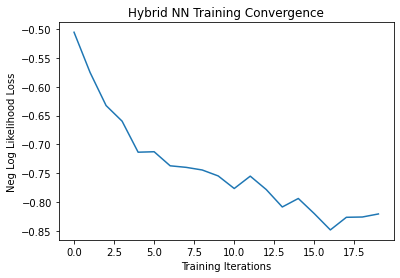

In [17]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list2 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list2.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list2[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list2)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Training [3%]	Loss: -0.5247
Training [7%]	Loss: -0.6306
Training [10%]	Loss: -0.6419
Training [13%]	Loss: -0.7092
Training [17%]	Loss: -0.7050
Training [20%]	Loss: -0.7504
Training [23%]	Loss: -0.7574
Training [27%]	Loss: -0.7737
Training [30%]	Loss: -0.7666
Training [33%]	Loss: -0.7991
Training [37%]	Loss: -0.7854
Training [40%]	Loss: -0.8043
Training [43%]	Loss: -0.8164
Training [47%]	Loss: -0.8278
Training [50%]	Loss: -0.8323
Training [53%]	Loss: -0.8364
Training [57%]	Loss: -0.8558
Training [60%]	Loss: -0.8458
Training [63%]	Loss: -0.8736
Training [67%]	Loss: -0.8654
Training [70%]	Loss: -0.8443
Training [73%]	Loss: -0.8869
Training [77%]	Loss: -0.8809
Training [80%]	Loss: -0.8985
Training [83%]	Loss: -0.8786
Training [87%]	Loss: -0.9092
Training [90%]	Loss: -0.9031
Training [93%]	Loss: -0.8935
Training [97%]	Loss: -0.9095
Training [100%]	Loss: -0.9177


Text(0, 0.5, 'Neg Log Likelihood Loss')

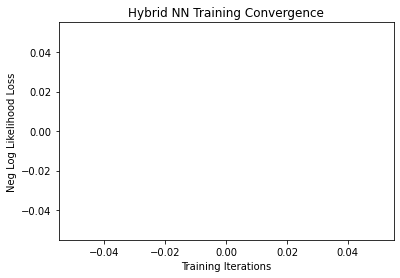

In [20]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list3 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list3)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Training [3%]	Loss: -0.4908
Training [7%]	Loss: -0.5495
Training [10%]	Loss: -0.6655
Training [13%]	Loss: -0.6473
Training [17%]	Loss: -0.7132
Training [20%]	Loss: -0.7230
Training [23%]	Loss: -0.7411
Training [27%]	Loss: -0.7624
Training [30%]	Loss: -0.7912
Training [33%]	Loss: -0.7937
Training [37%]	Loss: -0.7967
Training [40%]	Loss: -0.8212
Training [43%]	Loss: -0.8030
Training [47%]	Loss: -0.7887
Training [50%]	Loss: -0.8202
Training [53%]	Loss: -0.8327
Training [57%]	Loss: -0.8508
Training [60%]	Loss: -0.8667
Training [63%]	Loss: -0.8326
Training [67%]	Loss: -0.8536
Training [70%]	Loss: -0.8830
Training [73%]	Loss: -0.8841
Training [77%]	Loss: -0.8812
Training [80%]	Loss: -0.9019
Training [83%]	Loss: -0.8897
Training [87%]	Loss: -0.9042
Training [90%]	Loss: -0.9025
Training [93%]	Loss: -0.9058
Training [97%]	Loss: -0.8956
Training [100%]	Loss: -0.9056


Text(0, 0.5, 'Neg Log Likelihood Loss')

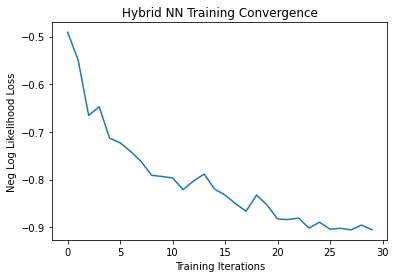

In [34]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

Testing the network

In [35]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

IndexError: ignored

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

Text(0, 0.5, 'Neg Log Likelihood Loss')

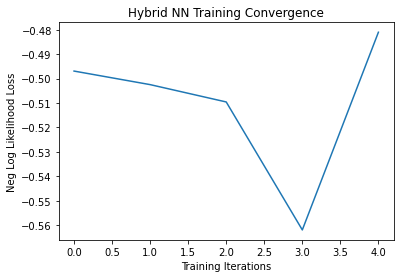

In [40]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [37]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.4869
Training [20%]	Loss: -0.5195
Training [30%]	Loss: -0.5255
Training [40%]	Loss: -0.5498
Training [50%]	Loss: -0.5054
Training [60%]	Loss: -0.4629
Training [70%]	Loss: -0.5347
Training [80%]	Loss: -0.5556
Training [90%]	Loss: -0.5504
Training [100%]	Loss: -0.5614


Text(0, 0.5, 'Neg Log Likelihood Loss')

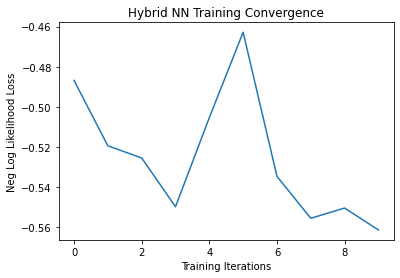

In [38]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [41]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.5175
Training [10%]	Loss: -0.4997
Training [15%]	Loss: -0.4714
Training [20%]	Loss: -0.5602
Training [25%]	Loss: -0.5107
Training [30%]	Loss: -0.5055
Training [35%]	Loss: -0.4933
Training [40%]	Loss: -0.4986
Training [45%]	Loss: -0.5039
Training [50%]	Loss: -0.5123
Training [55%]	Loss: -0.4799
Training [60%]	Loss: -0.5091
Training [65%]	Loss: -0.4969
Training [70%]	Loss: -0.5018
Training [75%]	Loss: -0.4464
Training [80%]	Loss: -0.5011
Training [85%]	Loss: -0.4896
Training [90%]	Loss: -0.5136
Training [95%]	Loss: -0.5157
Training [100%]	Loss: -0.4603


Text(0, 0.5, 'Neg Log Likelihood Loss')

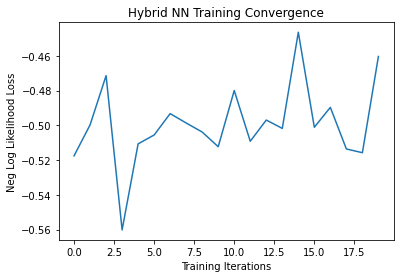

In [42]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [83]:
#Testing the  quantum hybrid in order to comapre it with the classical one
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

IndexError: ignored

In [80]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500,49)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [82]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 99)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)